In [34]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import h5py as h5
import numpy as np

import matplotlib.pyplot as plt
import cv2

### Structure of h5 files

In [46]:
# import file
f = h5.File('path/to/file.h5', 'r')

In [47]:
# there are two datasets: images and labels
list(f.keys())

['images', 'labels']

In [48]:
# shape of images dataset
dset_images = f['images']
dset_images.shape

(20000, 256, 256, 3)

In [50]:
# shape of labels dataset
dset_images = f['labels']
dset_images.shape

(20000,)

### Declare the gen class

In [42]:
class H5Gen(Sequence):
    def __init__(self, src, n_classes=2,
                 X_key='images',
                 y_key='labels',
                 batch_size=16,
                 shuffle=True,
                 normalize=True,
                 hot=True,
                 augmenter=None,
                 processors=None):
        self.file = h5.File(src, 'r')
        self.X_key = X_key
        self.y_key = y_key
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.hot = hot
        self.augmenter = augmenter
        self.processors = processors
        # Handle shuffle: new order of exploration
        self.shuffle = shuffle
        self.indices = np.arange(self.file[self.X_key].shape[0])

    def __len__(self):
        return int(np.floor(self.file[self.X_key].shape[0] / self.batch_size))

    def preprocess(self, batch_X):
        X_processed = []

        for x in batch_X:
            for p in self.processors:
                x = p.preprocess(x)

            X_processed.append(x)

        return np.array(X_processed)

    def hot_encode(self, batch_y):
        return to_categorical(batch_y, num_classes=self.n_classes)
    
    def normalize(self, X):
        return X.astype('float32') / 255.0

    def __getitem__(self, index):        
        inds = np.sort(self.indices[index * self.batch_size:(index + 1) * self.batch_size])
    
        batch_X = self.file[self.X_key][inds]
        batch_y = self.file[self.y_key][inds]
        
        if self.hot:
            batch_y = self.hot_encode(batch_y)
        
        if self.processors is not None:
            batch_X = self.preprocess(batch_X)
                    
        if self.augmenter is not None:
            (batch_X, batch_y) = next(self.augmenter.flow(batch_X, batch_y, batch_size=self.batch_size))
        
        batch_X = self.normalize(batch_X)
        
        return (batch_X, batch_y)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

### Optional: you can use pre-processors class

In [51]:
# example: a simple resizer pre-processor
class Resizer(object):
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    # must implement a preprocess method
    def preprocess(self, image):
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

### Optional: apply data augmentation

In [37]:
daug = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=8,
    zoom_range = 0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

In [38]:
# pre-processors
rp = Resizer(227, 227)

# create a custom h5 generator
train_gen = H5Gen('path/to/file.h5',
                  n_classes=2,
                  batch_size=32,
                  augmenter=daug,
                  processors=[rp])

### Generated images

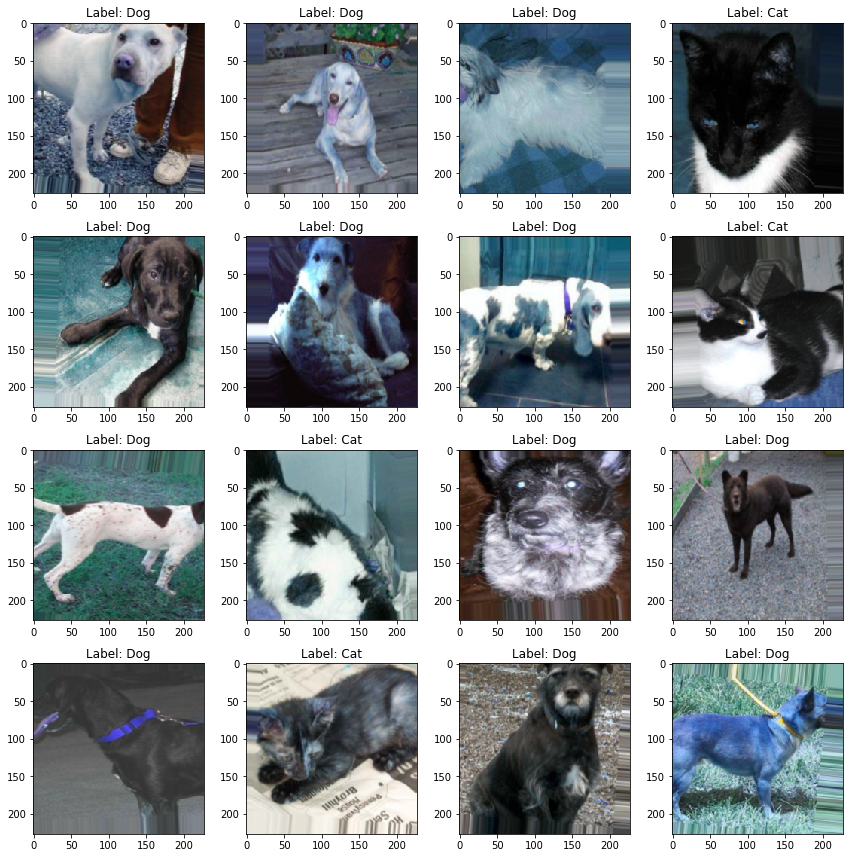

In [39]:
labels = ['Cat', 'Dog']

(samples_X, samples_y) = train_gen[0]

samples_X *= 255.0

fig, ax = plt.subplots(
    nrows=4,
    ncols=4,
    figsize=[12, 12]
)

for i, fig in enumerate(ax.flat):
    fig.set_title(f'Label: {hl[np.argmax(samples_y[i], axis=0)]}')
    fig.imshow(samples_X[i].astype('uint8'))

plt.tight_layout(True)

### Use it with your models

In [ ]:
h = model.fit_generator(
  train_gen,
  validation_data=test_gen,
  epochs=num_epochs,
  steps_per_epoch=len(train_gen),
  validation_steps=len(test_gen),
  verbose=1
)